In [1]:
import numpy as np
import random
import sympy as sp
import numpy.linalg as la

import control as pc

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
''' function A = getA(s,w,p)
Creates symbolic A Matrix with given vectors of symbol names.
Creates ordered A, first complex poles, then real poles
   w: symbols of real parts of complex poles
   s: symbols of imaginary part of complex poles
   p: symbols of purely real poles
   
   A: sympy symbolical matrix
'''
def getA(s,w,p):
    if not isinstance(w, tuple):
        w = (w,)
    if not isinstance(s, tuple):
        s = (s,)
    if not isinstance(p, tuple):
        p = (p,)
    A = sp.zeros(len(2*w+p), len(2*w)+len(p))
    for i,(v,r) in enumerate(zip(w,s)):
        XX = sp.Matrix([[r, v],[-v,r]])
        ix = 2*i
        A[ix, ix] = r
        A[ix+1, ix+1] = r
        A[ix, ix+1] = v
        A[ix+1, ix] = -v
    for i,r in enumerate(p):
        A[len(2*w)+i, len(2*w)+i] = r
    return A

# Test getA
#wx = sp.symbols('w_1:3')
#sx = sp.symbols('s_1:3')
#px = sp.symbols('p_1:3')
#sp.pprint(getA(wx,sx,px))



''' function A, (ss, s_init), (ws, w_init), (ps, p_init) = getA2(init_arr)

Creates symbolic A Matrix and tuples of ( (symbolic names), [given values]),
with given numerical vector of (complex) poles.
Creates A with the order of the given poles, and return tupels
to map the numerical values to the respective symbolic name.
   init_arr: (numpy) array of numerical poles
   
   ws: symbols of real parts of complex poles
   w_init: numerical values of real parts of complex poles
   ss: symbols of imaginary parts of complex poles
   s_init: numerical values of imaginary parts of complex poles
   ps: symbols of real poles
   p_init: numerical values of real poles
'''
def getA2(init_arr):
    num_cplx_poles = 0
    num_real_poles = 0
    A = None
    w_init = []
    ws = []
    s_init = []
    ss = []
    p_init = []
    ps = []
    
    for val in init_arr:
        if np.iscomplex(val):
            if np.conjugate(val) in init_arr:
                print "Ignored additional complex conjugate pole: {}".format(np.conjugate(val))
                init_arr.remove(np.conjugate(val))
            num_cplx_poles = num_cplx_poles + 1
            w = sp.symbols('w_{}'.format(num_cplx_poles)) # creates tuple (w_1)
            s = sp.symbols('s_{}'.format(num_cplx_poles)) # creates tuple (s_1)
            X = sp.Matrix([[s, w],[-w,s]])
            s_init.append(val.real)
            ss.append(s)
            w_init.append(val.imag)
            ws.append(w)
        else:
            num_real_poles = num_real_poles + 1
            p = sp.symbols('p_{}'.format(num_real_poles))
            X = sp.Matrix([p])
            p_init.append(val)
            ps.append(p)
        if A is None:
            A = X
        else:
            if not A:
                A = X
            else:
                A = A.row_insert(A.shape[0], sp.zeros(X.shape[0], A.shape[1]))
                A = A.col_insert(A.shape[1], sp.zeros(A.shape[1], X.shape[0]).row_insert(A.shape[0], X))
    return A, (tuple(ss), s_init), (tuple(ws), w_init), (tuple(ps), p_init)


# Test getA2()
#A, (ss, s_init), (ws, w_init), (ps, p_init) = getA2([-1, 2+3j, -2])
#sp.pprint(A)
#print ss, s_init
#print ws, w_init
#print ps, p_init

In [3]:
## Helper functions

''' Create sympy vector from symbols tuple
'''
def to_sympy_vector(syms):
    return sp.Matrix(syms)
sp.pprint(to_sympy_vector(sp.symbols('w_1:5')))



''' Lookup of numerical value from 'values' by mapping 'syms' on 'all_syms'
     -> Slower than 'get_accessor' function
'''
def get_value_by_symbol(values, all_syms, syms):
    res = []
    for sy in syms:
        idx = list(all_syms).index(sy)
        res.append(values[idx])
    return np.array(res).squeeze()

# Test 
#wx = sp.symbols('w_1:3')
#sx = sp.symbols('s_1:3')
#assert(np.all(get_value_by_symbol(np.arange(len(sx+wx)), sx+wx, sx) == np.arange(len(sx))))


''' Creates lamdified function to lookup 'syms' in a vector structured like 'all_syms'
     -> Faster than 'get_value_by_symbol', yet less general (error prone if structure changes)
'''
def get_accessor(all_syms_vector, syms):
    return sp.lambdify(all_syms_vector, syms)


⎡w₁⎤
⎢  ⎥
⎢w₂⎥
⎢  ⎥
⎢w₃⎥
⎢  ⎥
⎣w₄⎦


In [4]:
'''
Unroll for np.matrix instead of np.array
'''
def _c(M):
    if isinstance(M, np.matrix):
        print "Try to avoid numpy matrices"
        sh = M.shape
        if sh[0] == 1:
            return M.tolist()[0]
        elif sh[1] == 1:
            return M.T.tolist()[0]
        else:
            print "WARNING! Unrolling can go horribly wrong with matrizes!"
            return M.ravel().tolist[0]
    elif isinstance(M, np.ndarray):
        return M
    else:
        raise ValueError('No numpy input to unroll')

#_c(np.matrix([1,2,3]))
#_c(np.matrix([1,2,3]))
#_c([1,2,3]

In [5]:
''' Define Idetification System model with initial values
System is characterized by number of poles given with numerical values
'''

### Define poles with initial values
# SET_PARAMETER
num_poles = [-2+3j, -2]


A, (s, s_init), (w, w_init), (p, p_init) = getA2(num_poles)
num_cplx_poles = len(s_init)
num_real_poles = len(p_init)

# Define all symbolic names in sympy tuples
b = sp.symbols('b_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (b_1, b_2, b_3, b_4)
d = sp.symbols('d_1:2') # creates tuple (d_1)
x = sp.symbols('x_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (x_1, x_2, x_3, x_4)
c = sp.symbols('c_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (c_1, c_2, c_3, c_4)

u = sp.symbols('u_1:2')

# define structures / matrizes / vectors of symbols
X = to_sympy_vector(x)
U = to_sympy_vector(u)

B = to_sympy_vector(b)
C = to_sympy_vector(c).T
D = to_sympy_vector(d)

z = x+s+w+p+b+c+d # tuple of all symbols in Z (state vector)
Z = to_sympy_vector(z)

zu = z+u

fx = A*X+B*U # State space representation -> This changes over time (has dynamics)
f = sp.Matrix([0 for _ in range(len(z)-len(x))]) # -> All parameters do not have dynamics but shall remain the same (the correct estimate)
f = fx.col_join(f) # join together for full state transition vector
print "f="; sp.pprint(f)

F = f.jacobian(z) # First order derivitive of f
print "F="; sp.pprint(F)

h = C*X+D*U
print "h="; sp.pprint(h)

H = h.jacobian(z) # First order derivitive of h
print "H="; sp.pprint(H)



# Create (fast) numericial functions to get numerical matrices/vectors with given values
# ("paste values to the right positions")

AA = sp.lambdify(z, A)
BB = sp.lambdify(z, B)
CC = sp.lambdify(z, C)
DD = sp.lambdify(z, D)


ff = sp.lambdify(zu, f)
FF = sp.lambdify(zu, F)

hh = sp.lambdify(zu, h)
HH = sp.lambdify(zu, H)


f=
⎡b₁⋅u₁ + s₁⋅x₁ + w₁⋅x₂⎤
⎢                     ⎥
⎢b₂⋅u₁ + s₁⋅x₂ - w₁⋅x₁⎥
⎢                     ⎥
⎢    b₃⋅u₁ + p₁⋅x₃    ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎣          0          ⎦
F=
⎡s₁   w₁  0   x₁  x₂   0   u₁  0   0   0  0  0  0⎤
⎢                                                ⎥
⎢-w₁  s₁  0   x₂  -x₁  0   0   u₁  0   0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   p₁  0    0   x₃  0   0   u₁  0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   0   0    0   0   0   0   0   0  0  0  0⎥
⎢                                    

In [6]:
# Define R and Q

R = np.eye(len(d)) * 1.0
print "R:", R

# SET_PARAMETER
rho = 0.5

q = np.array([])
for sym in z:
    if sym in X.T.row_join(C):
        q = np.hstack((q, 0))
    else:
        q = np.hstack((q, 1))

Q = rho * np.diag(q)
print "Q:\n", Q

R: [[1.]]
Q:
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]]


In [7]:
# Sampling time
# SET_PARAMETER
iekf_fqz = 250
iekf_T = 1.0/iekf_fqz

# Modellabtastung
T = 1.0/1000
T_max = 600 #

In [8]:
import control as con

Af = np.array([[  0.,         -11.06378158],
               [100.,         -74.7335531 ]]
)

Bf = np.array([[-11.11006912],
               [  0.        ]])

Cf = np.array([[ 0., -1.]])

Df = np.array([[ 0.]])

Tf = 0.03306113

pade_order = 3

ss2 = con.ss(Af, Bf, Cf, Df)
#plt.plot(*con.step_response(ss2))
#plt.show()

print con.dcgain(ss2)
print ss2.pole()

# pade approx
numerator, denominator = con.pade(Tf, pade_order)

tf3 = con.series(ss2, con.tf(numerator,denominator))
ss3 = con.tf2ss(tf3)

#plt.plot(*con.step_response(ss3))
#plt.show()

Af = ss3.A
Bf = ss3.B
Cf = ss3.C
Df = ss3.D

print ss3

### Testsystem ####
xx_0 = np.zeros((len(Bf),1))

x_t_real = xx_0
def calc_TestSystem(u):
    global Af, Bf, Cf, Df, x_t_real

    #print "Af:\n", Af
    #print "x_t:\n", x_t_real
    x_dot = Af.dot(x_t_real)
    x_dot = x_dot + Bf.dot(u)
    y = Cf.dot(x_t_real) + Df.dot(u)
    
    #print x_dot
    x_t_real = x_t_real + x_dot*T

    return y

[[1.0041837]]
[-54.39316289 -20.34039021]
A = [[-9.94759830e-14  7.33817988e-14  6.60095341e-14  4.57602705e-14
   3.67393746e+00]
 [ 1.00000000e+02  5.61019710e-14  4.33963367e-14 -5.47567951e-14
   3.08899128e+01]
 [ 0.00000000e+00 -1.00000000e+02  7.18998157e-14 -1.71533536e-13
  -7.82460267e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+02 -3.14481925e-14
   8.31248282e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+03
  -4.37697553e+02]]

B = [[ 36.89308114]
 [-60.98634759]
 [-40.32555132]
 [-11.11006912]
 [  0.        ]]

C = [[ 0.   0.   0.   0.  -0.1]]

D = [[0.]]



In [9]:
# return real part of a vector
def real_vector(vector):
    return map(lambda x: x.real, vector)

# return imaginary part of a vector
def imag_vector(vector):
    return map(lambda x: x.imag, vector)

In [10]:
# initial
random.seed(42) # Set the random number generator to a fixed sequence.
np.random.seed(123) # Set the random number generator for fixed step length t


# Assign initial values to the poles
s_k0 = np.array([s_init])
#print s_k0, s_k0.shape
w_k0 = np.array([w_init])
#print w_k0, w_k0.shape
p_k0 = np.array([p_init])
#print p_k0, p_k0.shape

# Assign random values to the state space system
b_k0 = np.random.rand(len(b), 1)
#print b_k0, b_k0.shape
c_k0 = np.random.rand(1, len(c))
#print c_k0, c_k0.shape
d_k0 = np.zeros((len(d), len(d)))
#print d_k0, d_k0.shape

# Initial P
P_k0 = np.eye(len(z))
#print P_k0, P_k0.shape

# initial x0
x_k0 = np.zeros((len(x),1))
#print x_k0, x_k0.shape

# first step height u, also mean step height for all steps
u_k0 = np.array([[0.1]])

# first step time
step_time = 0.1


# First values
x_k = x_k0
#print x_k0, x_k0.shape

u_k = u_k0
#print u_k, u_k.shape

z_k = np.hstack((x_k0.T, s_k0, w_k0, p_k0, b_k0.T, c_k0, d_k0)).T
#print z_k, z_k.shape
P_k = P_k0
#print P_k, P_k.shape

# naive Logging 
poles = []
y = []
y_e = []
t_ye = []

u = []
nor0 = []
nor1 = []
nor2 = []
nor3 = []
nor4 = []

step_cnt = 1

# Create accessors
x_from_z = get_accessor(Z, to_sympy_vector(x))
s_from_z = get_accessor(Z, to_sympy_vector(s))
w_from_z = get_accessor(Z, to_sympy_vector(w))
p_from_z = get_accessor(Z, to_sympy_vector(p))

swp_from_z = get_accessor(Z, to_sympy_vector(s+w+p))

b_from_z = get_accessor(Z, to_sympy_vector(b))
c_from_z = get_accessor(Z, to_sympy_vector(c))
d_from_z = get_accessor(Z, to_sympy_vector(d))

In [11]:
%%time
##########################################################
# Loop start
for cnt, t in enumerate(np.arange(T, T_max, T)):

    ####################################################
    # Every time_step a new step is performed
    if np.isclose(t, step_time, T):
        u_k = u_k0 + random.uniform(-1, 1) # random step height
        
        step = np.random.randint(low=0, high=3000)*T
        step_time = step + t # random step length

        #print "step @ {} for {}: u={}".format(t, step, u_k)
        
        # >>> Logging of pole trajectories
        s_k = np.array(s_from_z(*z_k.ravel())).T
        w_k = np.array(w_from_z(*z_k.ravel())).T
        p_k = np.array(p_from_z(*z_k.ravel())).T
        poles.append(np.array([complex(si,wi) for si,wi in zip(s_k, w_k)] +
                              [complex(si,-wi) for si,wi in zip(s_k, w_k)] +
                              [pi for pi in p_k]))
        
        step_cnt = step_cnt + 1
        #print u_k, type(u_k), u_k.shape
        
    # >>> Logging of u
    u.append(u_k[0,0])
    
    ####################################################
    
    ##### Get system response y
    y_t = calc_TestSystem(u_k)
    #print u_k, u_k.shape
    #print y_t, y_t.shape
    
    # >>> Logging of y
    y.append(y_t[0,0])
    
    # Works only for integer divisions of frequencies!
    if cnt%int(iekf_T/T) == 0:
        t_ye.append(t)
        
        ##### Reconstruction from z (current state of estimation)
        #print z_k, z_k.shape, type(z_k)
        x_k = x_from_z(*z_k.ravel())
        #print x_k, x_k.shape, type(x_k)

        swp_k = np.array(swp_from_z(*z_k.ravel()))
        #print s_k0, w_k0, p_k0
        #print swp_k, swp_k.shape
        b_k = np.array(b_from_z(*z_k.ravel()))
        #print b_k0, b_k0.shape
        #print b_k, b_k.shape
        c_k = np.array(c_from_z(*z_k.ravel())).T
        #print c_k0, c_k0.shape
        #print c_k, c_k.shape
        d_k = np.array(d_from_z(*z_k.ravel()))
        #print d_k0, d_k0.shape
        #print d_k, d_k.shape

        ## Recreate System matrices from z
        A_k = AA(*z_k.ravel())
        #print A_k, type(A_k), A_k.shape
        B_k = BB(*z_k.ravel())
        #print B_k, type(B_k), B_k.shape
        C_k = CC(*z_k.ravel())
        #print C_k, type(C_k), C_k.shape
        D_k = DD(*z_k.ravel())
        #print D_k, type(D_k), D_k.shape

        ##### Evaluation
        # State space equation
        dx_k = A_k.dot(x_k) + B_k.dot(u_k)
        #print dx_k, dx_k.shape
        y_k = C_k.dot(x_k) + D_k.dot(u_k)
        #print y_k, y_k.shape

        # >>> Logging of estimated y (y_e) according to current state z
        y_e.append(y_k[0,0])


        # Concate values for lambdafied lookups
        zu_k = np.vstack((z_k, u_k.T))
        #print zu_k, zu_k.shape

        # current h
        h_k = hh(*zu_k.ravel()) # h = y_k (predicted)
        #print h_k,h_k.shape

        # Current H 
        H_k = HH(*zu_k.ravel()) # h.Jacobian
        #print H_k, H_k.shape

        # Current f
        f_k = ff(*zu_k.ravel()) # f
        #print f_k, f_k.shape

        # Current F
        F_k = FF(*zu_k.ravel()) #f.Jacobian
        #print F_k, F_k.shape



        ##### Time discrete Kalman Filter (DKF)

        # Correction error covariance P_k1 = P + T*(F*P*F^T + Q)
        P_k1 = P_k + iekf_T*(F_k.dot(P_k) + P_k.dot(F_k.T) + Q)
        #print "P_k1:\n", P_k1, P_k1.shape
        #print P_k, P_k.shape

        # Compute Kalman gain: K = P_k * H^T * (H P_k H^T + R)^(-1)
        K_k = P_k1.dot(H_k.T).dot(la.inv(H_k.dot(P_k1).dot(H_k.T) + R))
        #print "K_k:\n", K_k, K_k.shape

        # Update estimate with measurements z_k
        # Innovation + Euler intergration
        # z*_k = z_k + T*f_k* K*(y_t - h_k)
        z_k1 = (z_k + iekf_T*f_k + K_k.dot((y_t - h_k)))
        #print "z_k1:", z_k1, z_k1.shape, type(z_k1)
        #print "z_k:", z_k, z_k.shape, type(z_k)

        # Error covariance P*_k: P* = (I - KH)*P_k
        P_k = (np.eye(len(z)) - K_k.dot(H_k)).dot(P_k1) # P*_k
        #print "P_k:\n", P_k, P_k.shape

        # Project ahead
        z_k = np.array(z_k1) # y_t is numpy matrix for some reason
        #print "z_k:\n", z_k, z_k.shape, type(z_k)
        #P_k = P_k1
        #print "P_k:\n", P_k


        # Naive tracking of performance 
        nor0.append(np.trace(P_k))
        nor1.append(la.norm(P_k, 'fro'))
        nor2.append(la.norm(P_k, np.inf))
        nor3.append(la.norm(P_k, 1))
        nor4.append(la.norm(P_k, 2))
    
print "------------------"

------------------
CPU times: user 1min 17s, sys: 65.1 ms, total: 1min 17s
Wall time: 1min 17s


In [12]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    #start_ind = len(xdata) // 2
    #start_ind = len(xdata) * 1/3
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )
    
#t = np.linspace(-2, 2, 100)
#y = np.sin(t)
## return the handle of the line
#line = plt.plot(t, y)[0]
#add_arrow(line)

#plt.show()

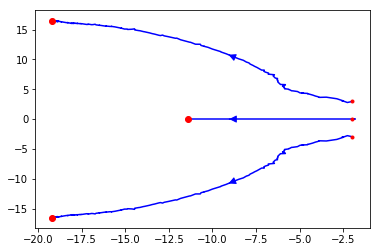

In [13]:
# another approach to plot
real_part = np.squeeze(real_vector(poles))
imag_part = np.squeeze(imag_vector(poles))
    
# Display a window with a plot of real, imag
line = plt.plot(real_part, imag_part, 'b-')
#plt.plot(real_part, imag_part, 'gx')
plt.plot(real_part[-1], imag_part[-1], 'ro')
plt.plot(real_part[0], imag_part[0], 'r.')

add_arrow(line[0], -9)
add_arrow(line[1], -9)
add_arrow(line[2], -9)
##zeros
#real_part = np.squeeze(real_vector(zeros))
#imag_part = np.squeeze(imag_vector(zeros))
    
# Display a window with a plot of real, imag
#plt.plot(real_part, imag_part, 'g-')
#plt.plot(real_part, imag_part, 'g')
#plt.plot(real_part[-1], imag_part[-1], 'rx')
#plt.plot(real_part[0], imag_part[0], 'bx')

#plt.xlim(-30, 1)
#plt.ylim(-25, 25)
plt.show()

In [14]:
#plt.rcParams['figure.figsize'] = [15, 7]
#import mpld3
#mpld3.enable_notebook()

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def every_nth(arr, n, T=1):
    return [T*np.array(range(0, len(arr))[::n]), arr[::n]]


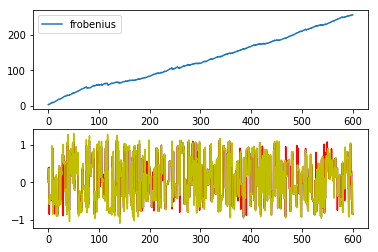

Done steps 495


In [15]:
tt = np.arange(T, T_max, T)

ax1 = plt.subplot(2, 1, 1)

#ax1.plot(*every_nth(nor0, 100), label="trace")
ax1.plot(t_ye, nor1, label="frobenius")
#ax1.plot(*every_nth(nor1, 100, iekf_T), label="frobenius")
#ax1.plot(*every_nth(nor2, 100), label="inf norm")
#ax1.plot(*every_nth(nor3, 100), label="1 norm")
#ax1.plot(*every_nth(nor4, 100), label="2 norm")

#ax1.plot(*every_nth(0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 2000), -1), 100), label="roll dist 2000")
##roll_dist_5000 = 0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 5000), -1)
##ax1.plot(*every_nth(roll_dist_5000, 100), label="roll dist 5000")

#mux_5000 = nor1[0:len(roll_dist_5000)] * roll_dist_5000
#ax1.plot(*every_nth(mux_5000, 100), label="mux")
#ax1.plot(*every_nth(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 2000), -1), 100), label="roll dist^2 2000")
#ax1.plot(*every_nth(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 5000), -1), 100), label="roll dist^2 5000")

ax1.legend()
#  H-inf Norm in mov-window
#  Entropy in mov-window
#  Highpass

ax2 = plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(tt, y, 'b', label="real y")
plt.plot(tt, u, 'r', label="setp u")
plt.plot(t_ye, y_e, 'y-', label="esti y")

plt.show()

print "Done steps", step_cnt

In [16]:
#print A_k, A_k.shape
#print b_k, b_k.shape
#print c_k, c_k.shape
#print d_k, d_k.shape

ss = pc.ss(A_k, b_k, c_k, d_k)

#print poles[-1]
print ss

A = [[-19.18125728  16.52289683   0.        ]
 [-16.52289683 -19.18125728   0.        ]
 [  0.           0.         -11.38774556]]

B = [[-15.23297513]
 [ -1.10302069]
 [  5.90087973]]

C = [[1.02844373 2.18482987 1.28975963]]

D = [[0.04865181]]



In [17]:
print pc.dcgain(ss3)
print ss3.pole()
print ss3.zero()
print "----"
print pc.dcgain(ss)
print ss.pole()
print ss.zero()

[[1.0041837]]
[-111.24285968+106.12952188j -111.24285968-106.12952188j
 -140.47828097  +0.        j  -54.39316289  +0.        j
  -20.34039021  +0.        j]
[-1.95450403e+15  +0.       j  1.11242860e+02+106.1295219j
  1.11242860e+02-106.1295219j  1.40478281e+02  +0.       j]
----
[[1.0047461]]
[-19.18125728+16.52289683j -19.18125728-16.52289683j
 -11.38774556 +0.        j]
[ 90.60373016+36.07954005j  90.60373016-36.07954005j
 -15.84848771 +0.        j]


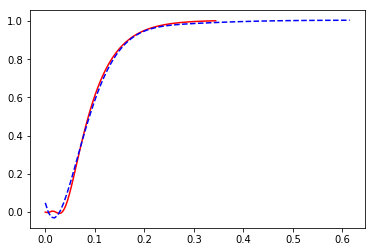

In [18]:
yout3, T3 = pc.step_response(ss3)
plt.plot(yout3, T3, 'r')
#plt.show()

yout4, T4 = pc.step_response(ss)
plt.plot(yout4, T4, 'b--')

plt.show()